<a href="https://colab.research.google.com/github/jonahschimpf/diabetes_clf/blob/master/jonahschimpf_diabetes_clf.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Author: Jonah Schimpf

Motivation: Here is a basic machine learning project which creates a basic decision tree to predict diabetes using various correlated factors (see below). 
This decision tree was built using a self-constructed cross validated accuracy algorithm to assess accuracy, and an algorithm which which finds the best CCP alpha paramter through cross validated accuracy as well (using an sklearn function which generates possible values). In the epilogue, I assess my algorithm against the built in sklearn functions which do the same thing, and also generate a plot of my tree using the handy graphviz library.

In [1]:
import random 
import numpy as np
import pandas as pd
import sklearn as sk
from scipy import stats
import scipy.sparse as sp
import random as r
from sklearn import tree
random.seed(42)  #set a random seed for testing purposes
from google.colab import drive
drive.mount('/content/drive')


Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
# Load all data tables
basedir = '/content/drive/My Drive/Colab Notebooks/'
df = pd.read_csv(basedir + "diabetes_labeled_dataset.csv")
matrix = df.corr() #this matrix is the list of correlated variables for diabetes, this takes awhile so be careful running this cell more than once

In [3]:
matrixOfDiabetes = matrix[["DIABETIC"]] #here, we are only interested in the correlation column for diabetes
sortedCor = matrixOfDiabetes.sort_values(by = ["DIABETIC"], ascending = False)
sortedCor = sortedCor.dropna()
sortedCor = sortedCor[sortedCor["DIABETIC"] > .25]
df["MCQ240DK"].isnull().sum(axis = 0) / len(df)
print(sortedCor)
df

          DIABETIC
DIABETIC  1.000000
MCQ240T   1.000000
OSD110G   1.000000
MCQ240DK  0.987829
MCQ240AA  0.802955
OSQ090G   0.577350
LBDSGLSI  0.540384
LBXSGL    0.540367
LBXGLT    0.538181
LBDGLTSI  0.538179
GTDCODE   0.442646
DRD370SQ  0.383136
RHQ602U   0.377964
RIDAGEYR  0.361037
BMDAVSAD  0.316132
BMXSAD2   0.315998
BMXSAD1   0.315870
BMXWAIST  0.307331
DUQ380A   0.299050
BMXSAD4   0.298782
BMXSAD3   0.297487
OSD050BA  0.291866
SMQ849    0.287757
MCQ240BB  0.279457
RHQ031    0.279208
DMDHHSZE  0.275405
HUQ010    0.271951
DMDHRAGE  0.269055
DUQ310Q   0.268349
BMXBMI    0.261281
LBXSOSSI  0.259347
SXQ267    0.258712
DUQ400Q   0.255183
BMXWT     0.253500


,SEQN,SDDSRVYR,RIDSTATR,RIAGENDR,RIDAGEYR,RIDAGEMN,RIDRETH1,RIDRETH3,RIDEXMON,RIDEXAGM,DMQMILIZ,DMQADFC,DMDBORN4,DMDCITZN,DMDYRSUS,DMDEDUC3,DMDEDUC2,DMDMARTL,RIDEXPRG,SIALANG,SIAPROXY,SIAINTRP,FIALANG,FIAPROXY,FIAINTRP,MIALANG,MIAPROXY,MIAINTRP,AIALANGA,DMDHHSIZ,DMDFMSIZ,DMDHHSZA,DMDHHSZB,DMDHHSZE,DMDHRGND,DMDHRAGE,DMDHRBR4,DMDHREDU,DMDHRMAR,DMDHSEDU,...,SXQ280,SXQ292,SXQ294,WHD010,WHD020,WHQ030,WHQ040,WHD050,WHQ060,WHQ070,WHD080A,WHD080B,WHD080C,WHD080D,WHD080E,WHD080F,WHD080G,WHD080H,WHD080I,WHD080J,WHD080K,WHD080M,WHD080N,WHD080O,WHD080P,WHD080Q,WHD080R,WHD080S,WHD080T,WHD080U,WHD080L,WHD110,WHD120,WHD130,WHD140,WHQ150,WHQ030M,WHQ500,WHQ520,DIABETIC
0,76195,8,2,1,18,NaN,5,7,1.0,217.0,2.0,NaN,1,1.0,NaN,10.0,NaN,NaN,NaN,1,2.0,2,1.0,2.0,2.0,1.0,2.0,2.0,1.0,5,5,0,0,0,1,55,1.0,2.0,1.0,3.0,...,NaN,1.0,NaN,67.0,138.0,3.0,3.0,120.0,NaN,2.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,138.0,18.0,NaN,NaN,NaN,0
1,76958,8,2,2,57,NaN,2,2,1.0,NaN,2.0,NaN,1,1.0,NaN,NaN,3.0,1.0,NaN,1,2.0,2,1.0,2.0,2.0,1.0,2.0,2.0,1.0,6,6,1,0,1,1,27,1.0,4.0,6.0,NaN,...,NaN,NaN,1.0,67.0,142.0,3.0,2.0,150.0,NaN,2.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,135.0,115.0,67.0,150.0,45.0,NaN,NaN,NaN,0
2,80248,8,2,2,29,NaN,2,2,2.0,NaN,2.0,NaN,1,1.0,NaN,NaN,4.0,1.0,2.0,1,2.0,2,1.0,2.0,2.0,1.0,2.0,2.0,1.0,3,3,1,0,0,2,29,1.0,4.0,1.0,5.0,...,NaN,NaN,1.0,67.0,137.0,3.0,2.0,150.0,1.0,NaN,NaN,NaN,NaN,13.0,NaN,NaN,NaN,NaN,NaN,32.0,NaN,34.0,30.0,41.0,NaN,43.0,NaN,45.0,46.0,NaN,NaN,NaN,125.0,NaN,160.0,28.0,NaN,NaN,NaN,0
3,80213,8,2,2,0,5.0,1,1,2.0,6.0,NaN,NaN,1,1.0,NaN,NaN,NaN,NaN,NaN,1,1.0,2,1.0,2.0,2.0,NaN,NaN,NaN,NaN,5,5,1,0,0,1,33,1.0,4.0,1.0,5.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0
4,76753,8,2,1,61,NaN,3,3,2.0,NaN,2.0,NaN,1,1.0,NaN,NaN,3.0,6.0,NaN,1,2.0,2,1.0,2.0,2.0,1.0,2.0,2.0,1.0,6,6,0,0,2,2,52,1.0,4.0,6.0,NaN,...,NaN,NaN,NaN,69.0,160.0,2.0,1.0,160.0,NaN,2.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,160.0,160.0,69.0,180.0,30.0,NaN,NaN,NaN,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8135,74555,8,1,2,2,NaN,5,7,NaN,NaN,NaN,NaN,1,1.0,NaN,NaN,NaN,NaN,NaN,1,1.0,2,1.0,2.0,2.0,NaN,NaN,NaN,NaN,4,4,2,0,0,1,32,1.0,5.0,1.0,5.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0
8136,75795,8,2,1,79,NaN,1,1,1.0,NaN,2.0,NaN,2,1.0,9.0,NaN,1.0,1.0,NaN,2,1.0,2,2.0,2.0,2.0,2.0,2.0,2.0,NaN,2,2,0,0,2,2,71,2.0,1.0,1.0,1.0,...,NaN,NaN,NaN,70.0,200.0,1.0,2.0,190.0,NaN,2.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,150.0,140.0,70.0,200.0,79.0,NaN,NaN,NaN,0
8137,75171,8,2,2,17,NaN,4,4,1.0,205.0,2.0,NaN,1,1.0,NaN,11.0,NaN,NaN,NaN,1,2.0,2,1.0,2.0,2.0,1.0,2.0,2.0,1.0,7,7,2,4,0,2,34,1.0,4.0,5.0,NaN,...,NaN,NaN,NaN,68.0,200.0,1.0,2.0,171.0,NaN,2.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0
8138,77848,8,1,1,58,NaN,4,4,NaN,NaN,1.0,1.0,1,1.0,NaN,NaN,2.0,3.0,NaN,1,2.0,2,1.0,2.0,2.0,NaN,NaN,NaN,NaN,1,1,0,0,0,1,58,1.0,2.0,3.0,NaN,...,NaN,NaN,NaN,65.0,207.0,1.0,2.0,216.0,NaN,1.0,10.0,NaN,12.0,13.0,14.0,NaN,NaN,NaN,NaN,32.0,NaN,34.0,NaN,41.0,NaN,43.0,44.0,45.0,46.0,NaN,NaN,175.0,153.0,64.0,225.0,54.0,NaN,NaN,NaN,0


# Preprocessing

Here, I limit my features for diabetes prediction to age, waist and leg circumference, BMI, diagnosis of pancreatic cancer, and lipid samples which are strongly correlated with a diabetes diagnosis. I then fill in the the missing samples with the median for nominal features (features that are numeric) and for the missing features associated with categorical features, I fill with the mode.

In [4]:

dfRefined = df[["RIDAGEYR", "BMXWAIST", 'BMXLEG', 'BMXWT','BMXBMI',  'DIABETIC', "OSD110G", "MCQ240T", "MCQ240DK", "MCQ240AA", "LBDSGLSI", "LBXSGL", "LBXGLT", "LBDGLTSI"]]
dfNominalFeatures = dfRefined.drop([ "DIABETIC", "OSD110G", "MCQ240T", "MCQ240DK", "MCQ240AA"], axis = 1)
dfCategoricalFeatures = dfRefined[["DIABETIC", "OSD110G", "MCQ240T", "MCQ240DK", "MCQ240AA"]]
pastNominalFeaturesMedian = dfNominalFeatures.median()
dfNominalFeatures = dfNominalFeatures.fillna(pastNominalFeaturesMedian)
dfCategoricalFeatures = dfCategoricalFeatures.fillna(0, axis = 0)
dfRefined = pd.concat([dfNominalFeatures, dfCategoricalFeatures], axis = 1)
diabeticColumn = dfRefined[["DIABETIC"]]
dfRefined = dfRefined.drop(["DIABETIC"], axis = 1)
dfRefined["DIABETIC"] = diabeticColumn
dfRefined

,RIDAGEYR,BMXWAIST,BMXLEG,BMXWT,BMXBMI,LBDSGLSI,LBXSGL,LBXGLT,LBDGLTSI,OSD110G,MCQ240T,MCQ240DK,MCQ240AA,DIABETIC
0,18,75.5,42.0,59.2,20.2,4.55,82.0,105.0,5.829,0.0,0.0,0.0,0.0,0
1,57,90.7,39.0,61.8,21.1,5.44,98.0,144.0,7.993,0.0,0.0,0.0,0.0,0
2,29,81.2,40.0,63.1,22.1,4.50,81.0,105.0,5.829,0.0,0.0,0.0,0.0,0
3,0,87.8,38.6,6.8,24.7,5.16,93.0,105.0,5.829,0.0,0.0,0.0,0.0,0
4,61,77.2,41.5,65.8,21.7,5.72,103.0,98.0,5.440,0.0,0.0,0.0,0.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8135,2,87.8,38.6,65.3,24.7,5.16,93.0,105.0,5.829,0.0,0.0,0.0,0.0,0
8136,79,117.5,39.0,87.9,30.6,5.27,95.0,233.0,12.934,0.0,0.0,0.0,0.0,0
8137,17,108.7,41.7,90.4,31.7,5.16,93.0,105.0,5.829,0.0,0.0,0.0,0.0,0
8138,58,87.8,38.6,65.3,24.7,5.16,93.0,105.0,5.829,0.0,0.0,0.0,0.0,0


## **Functions**

Here, are implement the function for cross validated accuracy and for automatic dt pruning. 



In [0]:
def cross_validated_accuracy(DecisionTreeClassifier, X, y, num_trials, num_folds, random_seed):
  random.seed(random_seed)
  """
   Args:
        DecisionTreeClassifier: An Sklearn DecisionTreeClassifier (e.g., created by "tree.DecisionTreeClassifier(criterion='entropy')")
        X: Input features
        y: Labels
        num_trials: Number of trials to run of cross validation
        num_folds: Number of folds (the "k" in "k-folds")
        random_seed: Seed for uniform execution (Do not change this) 

    Returns:
        cvScore: The mean accuracy of the cross-validation experiment

    Notes:
        1. You may NOT use the cross-validation functions provided by Sklearn
  """
  scores = np.zeros(num_trials * num_folds)
  scores.shape = (num_trials, num_folds)
  for i in range(num_trials) : #out loop controlling trials being performed
    testIndexList = getStrat(num_folds, X, random_seed)
    for j in range(num_folds) : #inner loop generating folds
      currentTestIndices = testIndexList[j]
      X_train = X.drop(currentTestIndices)
      y_train = y.drop(currentTestIndices)
      X_test = X.iloc[currentTestIndices]
      y_test = y.iloc[currentTestIndices]
      DecisionTreeClassifier = DecisionTreeClassifier.fit(X_train, y_train)
      X_test.to_numpy()
      scores[i, j] = DecisionTreeClassifier.score(X_test.to_numpy(), y_test)
  scores = np.mean(scores, axis= 1)
  scores = np.mean(scores)
  cvScore = scores
  return cvScore

In [0]:

def getStrat(folds, data, random_state) :
	# import pdb; pdb.set_trace()
	x = len(data)
	dataset_copy = [i for i in range(x)]
	fold_size = int((len(dataset_copy)) / folds)
	entireFold = []
	for i in range(folds):
		testIndices = []
		while len(testIndices) < fold_size:
			index = r.randrange(len(dataset_copy)) #generates an index in the range of the dataset_copy
			removedIndex = dataset_copy.pop(index) #removes the element in the index
			testIndices.append(removedIndex) #append the removedIndex
		entireFold.append(testIndices)
	return entireFold

In [7]:
clf = tree.DecisionTreeClassifier(criterion='entropy')
accuracy = cross_validated_accuracy(clf, dfRefined.drop(["DIABETIC"], axis = 1), dfRefined.iloc[:, -1], 20, 3, 42)
print("accuracy", accuracy)
from sklearn import datasets, linear_model
from sklearn.model_selection import cross_val_score
accuracy2 = cross_val_score(clf, dfRefined.drop(["DIABETIC"], axis = 1), dfRefined.iloc[:, -1], cv=3, scoring = "accuracy")
print("accuracy2", accuracy2.mean())

accuracy 0.9175512962280379
accuracy2 0.9126534694755991


In [0]:
def automatic_dt_pruning(DecisionTreeClassifier, X, y, num_trials, num_folds, random_seed):
  random.seed(random_seed)
  """
  Returns the pruning parameter (i.e., ccp_alpha) with the highest cross-validated accuracy

  Args:
        DecisionTreeClassifier  : An Sklearn DecisionTreeClassifier (e.g., created by "tree.DecisionTreeClassifier(criterion='entropy')")      
        X (Pandas.DataFrame)    : Input Features
        y (Pandas.Series)       : Labels
        num_trials              : Number of trials to run of cross validation
        num_folds               : Number of folds for cross validation (The "k" in "k-folds") 
        random_seed             : Seed for uniform execution (Do not change this)


    Returns:
        ccp_alpha : Tuned pruning paramter with highest cross-validated accuracy

    Notes:
        1. Don't change any other Decision Tree Classifier parameters other than ccp_alpha
        2. Use the cross_validated_accuracy function you implemented to find the cross-validated accuracy
      //get path , get list of possible alphas, get decision tree classifier for each alpha, 
  """

  path = DecisionTreeClassifier.cost_complexity_pruning_path(X, y)
  my_ccp_alphas = path.ccp_alphas
  my_ccp_alphas = my_ccp_alphas[:-1]
  maxAccuracy = 0
  maxAlpha = 0
  for my_ccp_alpha in my_ccp_alphas:
      DecisionTreeClassifier.ccp_alpha = my_ccp_alpha
      treeForAlpha = DecisionTreeClassifier
      thisCrossValidatedAccuracy = cross_validated_accuracy(treeForAlpha, X, y, num_trials, num_folds, random_seed)
      if maxAccuracy < thisCrossValidatedAccuracy :
        maxAccuracy = thisCrossValidatedAccuracy
        maxAlpha = my_ccp_alpha
  ccp_alpha = maxAlpha
  return ccp_alpha

## **Tuning and Testing**

Here I build my decision tree using the functions I created and algorithms from sklearn

In [9]:
clf = clf.fit(dfRefined.drop(["DIABETIC"], axis = 1), dfRefined.iloc[:, -1])
bestAlpha = automatic_dt_pruning(clf, dfRefined.drop(["DIABETIC"], axis = 1), dfRefined.iloc[:, -1], 1, 10, 42)

KeyboardInterrupt: ignored

In [0]:
#no pruning parameter
clf = tree.DecisionTreeClassifier(criterion='entropy')
accuracy = cross_validated_accuracy(clf, dfRefined.drop(["DIABETIC"], axis = 1), dfRefined.iloc[:, -1], 3, 3, 42)


#sklearn assesing accuracy
accuracy2 = cross_val_score(clf, dfRefined.drop(["DIABETIC"], axis = 1), dfRefined.iloc[:, -1], cv=3, scoring = "accuracy")

pruney_clf = tree.DecisionTreeClassifier(criterion = "entropy", ccp_alpha = bestAlpha)
pruney_accuracy = cross_validated_accuracy(pruney_clf, dfRefined.drop(["DIABETIC"], axis = 1), dfRefined.iloc[:, -1], 3, 3, 42)

print("skc accuracy", accuracy2.mean())
print("regular accuracy", accuracy)
print("pruney_accuracy", pruney_accuracy)
!pip install graphviz


skc accuracy 0.9138822574568639
regular accuracy 0.9181308105008806
pruney_accuracy 0.943277224884302


In [0]:
from sklearn.model_selection import train_test_split
X , y= dfRefined.drop(["DIABETIC"], axis = 1), dfRefined.iloc[:, -1]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)
#rest indices from the split
(X_train.reset_index(drop = True, inplace = True))
(X_test.reset_index(drop = True, inplace = True))
(y_train.reset_index(drop = True, inplace = True))
(y_test.reset_index(drop = True, inplace = True))

In [0]:
clf = tree.DecisionTreeClassifier(criterion='entropy')
bestAlpha = automatic_dt_pruning(clf, X_train, y_train, 1, 3, 42)
clf.ccp_alpha = bestAlpha
clf = clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)
print("Test error (pruned): " + str(((y_test != y_pred).sum()) / X_test.shape[0]) + "   N = " + str(X_test.shape[0]))
print(y_test.values)

Test error (pruned): 0.05855855855855856   N = 2442
[0 0 1 ... 1 0 0]


In [0]:
print(y_test.values)
print(clf.ccp_alpha)

[0 0 1 ... 1 0 0]
0.0029517885510425557


[0 0 0 ... 0 0 0]
Train error (Pruned): 0.052825552825552825   N = 5698
Test error (Pruned): 0.025096525096525095   N = 5698
unique values of test: [0 1]
unique values of prediction:  [0 1]


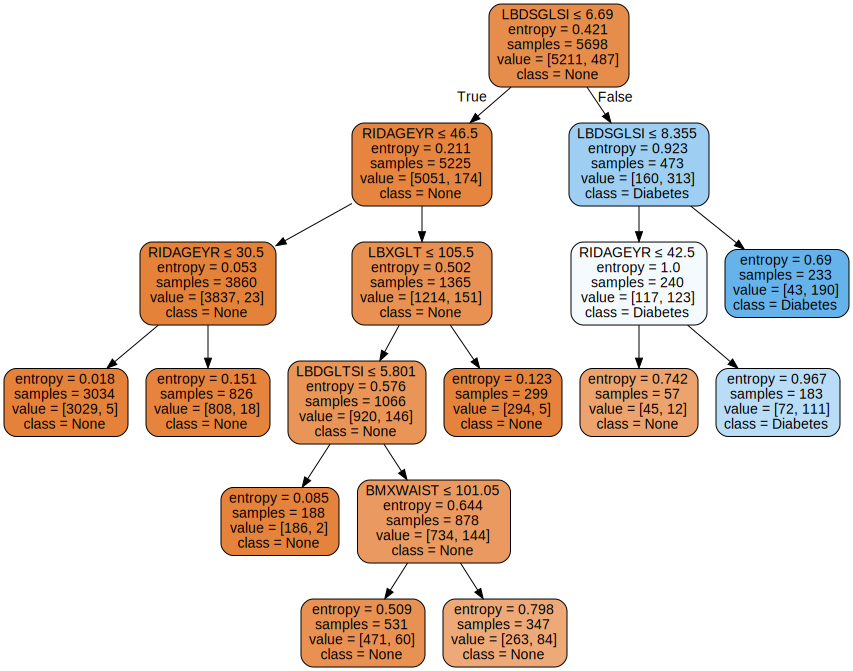

In [0]:
y_pred = clf.predict(X_train)
print(y_pred)
print("Train error (Pruned): " + str(((y_train != y_pred).sum()) / X_train.shape[0]) + "   N = " + str(X_train.shape[0]))
y_pred = clf.predict(X_test)

print("Test error (Pruned): " + str(((y_test != y_pred).sum()) / X_train.shape[0]) + "   N = " + str(X_train.shape[0]))
print("unique values of test:", y_test.unique())
print("unique values of prediction: ", np.unique(y_pred))

import graphviz 
dot_data = tree.export_graphviz(clf, out_file=None) 
graph = graphviz.Source(dot_data) 
graph.render("Pruned Tree") 
dot_data = tree.export_graphviz(clf, out_file=None, 
                     feature_names=X.columns,  
                     class_names=['None', 'Diabetes'],  
                     filled=True, rounded=True,  
                     special_characters=True)  
graph = graphviz.Source(dot_data)  
graph  

Here I predict on a completely unlabeled dataset, using the decision tree that I just created

In [0]:
#TESTING ON
#dfNominalFeatures = dfRefined.drop([ "DIABETIC", "OSD110G", "MCQ240T", "MCQ240DK", "MCQ240AA"], axis = 1)
# dfCategoricalFeatures = dfRefined[["DIABETIC", "OSD110G", "MCQ240T", "MCQ240DK", "MCQ240AA"]]
# pastNominalFeaturesMedian = dfNominalFeatures.median()
# dfNominalFeatures = dfNominalFeatures.fillna(pastNominalFeaturesMedian)
# dfCategoricalFeatures = dfCategoricalFeatures.fillna(0, axis = 0)
# dfRefined = pd.concat([dfNominalFeatures, dfCategoricalFeatures], axis = 1)
# diabeticColumn = dfRefined[["DIABETIC"]]
# dfRefined = dfRefined.drop(["DIABETIC"], axis = 1)
# dfRefined["DIABETIC"] = diabeticColumn
# dfRefined


dfTest = pd.read_csv(basedir + "diabetes_labeled_dataset.csv")
dfRefinedTest = dfTest[["RIDAGEYR", "BMXWAIST", 'BMXLEG', 'BMXWT','BMXBMI',  "OSD110G", "MCQ240T", "MCQ240DK", "MCQ240AA", "LBDSGLSI", "LBXSGL", "LBXGLT", "LBDGLTSI"]]
dfCategoricalFeaturesTest = dfRefinedTest[[ "OSD110G", "MCQ240T", "MCQ240DK", "MCQ240AA"]]
dfNominalFeaturesTest = dfRefinedTest.drop([ "OSD110G", "MCQ240T", "MCQ240DK", "MCQ240AA"], axis = 1)
dfCategoricalFeaturesTest = dfCategoricalFeaturesTest.fillna(0, axis = 1)
dfNominalFeaturesTest = dfNominalFeaturesTest.fillna(pastNominalFeaturesMedian)
dfRefinedTest = pd.concat([dfNominalFeaturesTest, dfCategoricalFeaturesTest], axis = 1)
print(dfRefinedTest)
testData = dfRefinedTest
y_pred_final = clf.predict(testData)
finalFrame = pd.DataFrame(y_pred_final)
finalFrame.iloc[:, 0].value_counts()
finalFrame.to_csv(basedir+"predictions.csv")

      RIDAGEYR  BMXWAIST  BMXLEG  BMXWT  ...  OSD110G  MCQ240T  MCQ240DK  MCQ240AA
0           12      94.1    44.0   76.8  ...      0.0      0.0       0.0       0.0
1            0      87.8    38.6    8.5  ...      0.0      0.0       0.0       0.0
2           21      81.5    47.8   77.3  ...      0.0      0.0       0.0       0.0
3           11      86.5    40.6   67.1  ...      0.0      0.0       0.0       0.0
4            6      49.8    38.6   17.4  ...      0.0      0.0       0.0       0.0
...        ...       ...     ...    ...  ...      ...      ...       ...       ...
2030        80     107.4    44.1   80.1  ...      0.0      0.0       0.0       0.0
2031         9      67.0    33.2   35.7  ...      0.0      0.0       0.0       0.0
2032        62     122.7    33.5  101.1  ...      0.0      0.0       0.0       0.0
2033        63      95.5    37.2   68.0  ...      0.0      0.0       0.0       0.0
2034        68      84.6    40.5   59.5  ...      0.0      0.0       0.0       0.0

[20